##### Grading Feedback Cell
107%

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [1]:
# read only cell

import os

# get the databricks runtime version
db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if the databricks env var exists
    if db_env != None:
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [2]:
# import statements here
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
# # # # #
import seaborn as sns
from pyspark.sql import functions as fn
from pyspark.ml.stat import Correlation
from pyspark.ml import feature, regression, evaluation, Pipeline

# Moore's Law
The frequently cited “Moore’s Law” originated with a 1965 article in Electronics magazine that said the number of transistors in a given area would double every year.

### ONLY use spark functions unless the question instructions say otherwise.

## Question 1 Load the Transistor Data (5 pts)
- Read the MooresLaw.txt file into a spark data frame named trans_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of trans_df 
- Print the shape of trans_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment

In [3]:
# your code here
# Read the MooresLaw.txt file into a spark data frame named trans_df using only spark.
raw_data = sc.textFile("MooresLaw.txt").map(lambda x: x.split("\t")) 
# Split string with delimiter "\t"
headers = raw_data.first() 
body = raw_data.filter(lambda x: x != headers)
# The columns is named as per the header in the txt file.
trans_df = body.toDF(headers) 
# remove the last 3 columns with empty strings
trans_df = trans_df.select(trans_df.columns[:3])
# type(trans_df) shows it is a pyspark.sql.dataframe.DataFrame

In [4]:
# Print the first 5 rows of trans_df
trans_df.show(5)

+---------------+------+-----------+
|Intel Processor|  Year|Transistors|
+---------------+------+-----------+
|           4004|1971.9|       2300|
|           8008|1972.3|       3500|
|           8080|1974.3|       6000|
|           8085|1976.3|       6500|
|           8086|1978.5|      29000|
+---------------+------+-----------+
only showing top 5 rows



In [5]:
# Print the shape of trans_df (num_rows, num_cols)
num_rows=trans_df.count()
num_cols=len(trans_df.columns)
shape=(num_rows,num_cols)
print(shape)

(74, 3)


##### Grading Feedback Cell

## Question 2 Transistor Data Cleanup (5 pts)
- Drop all columns in trans_df except the Year and Transistors column.
- Drop rows in trans_df that contain NaN vales
- Prove that trans_df does not contain NaN values by showing a single integer sum of the number of Nan values in the dataframe (should equal 0)

In [6]:
# your code here
# Drop all columns in trans_df except the Year and Transistors column.
trans_df=trans_df.select([c for c in trans_df.columns if c in {'Year','Transistors'}])
trans_df.show(5)
# print(trans_df.printSchema())

+------+-----------+
|  Year|Transistors|
+------+-----------+
|1971.9|       2300|
|1972.3|       3500|
|1974.3|       6000|
|1976.3|       6500|
|1978.5|      29000|
+------+-----------+
only showing top 5 rows



In [7]:
# convert the data type of Year and Transistors column to double
trans_df=trans_df.withColumn('Year',trans_df['Year'].cast('double'))
trans_df=trans_df.withColumn('Transistors',trans_df['Transistors'].cast('double'))

In [8]:
# Drop rows in trans_df that contain NaN vales
trans_df=trans_df.na.drop(how="all")

In [9]:
# Prove that trans_df does not contain NaN values 
# by showing a single integer sum of the number of Nan values in the dataframe (should equal 0)
trans_df.toPandas().isnull().sum().sum()

0

##### Grading Feedback Cell
-3 use of non spark methods to calculate sum

## Question 3 Transistor Data Exploration (10 pts)


### Question 3a (3 pts) 
Explore the data in trans_df by plotting transistors vs. year with a scatter plot.  You may use packages outside of spark to perform the task in question 3a.

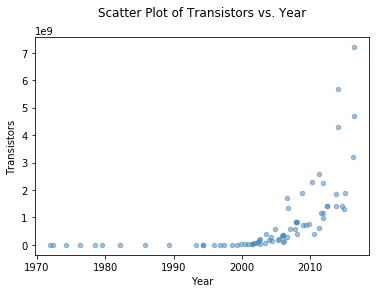

In [10]:
# Your code here
trans_df.select('Year','Transistors'). \
 toPandas().plot(x='Year',y='Transistors',kind='scatter', \
                                 color='steelblue',alpha=0.5, \
                                 title="Scatter Plot of Transistors vs. Year\n");

##### Grading Feedback Cell

### Question 3b (3 pts)
Compute the correlation between year and number of transistors in the trans_df using spark.  Print the resulting correlation value.  Interpret the correlation in words in the provided markdown cell.

In [11]:
# your code here
correlations = trans_df.select(fn.corr('Year','Transistors'))
correlations.show()

+-----------------------+
|corr(Year, Transistors)|
+-----------------------+
|     0.5434352929286301|
+-----------------------+



##### Grading Feedback Cell

### Question 3c (4 pts) 
- Interpret the correlation value computed above in the markdown cell below.

Your correlation interpretation here:<br/>
A correlation coefficient close to 1 means that there’s a very strong positive correlation between the two variables. A correlation coefficient close to 0 means that there is no linear relationship.<br/>
In our case, the correlation coefficient between year and number of transistors is about 0.54, which means there is a moderate positive relationship between year and number of transistors. The more recent, the higher number of transistors.

##### Grading Feedback Cell

## Question 4 Transform the Data (10 pts)

### Question 4a (5 pts)
- Create a new data frame named trans_df_2 that adds a log transform to the transistors col in trans_df.
- Print the head of trans_df_2
- Print the shape of trans_df_2

In [45]:
# your code here
# Create a new data frame named trans_df_2 that adds a log transform to the transistors col in trans_df.
trans_df_2=trans_df.withColumn('log_Transistors', fn.log('Transistors')) # the base is e, not 2 or 10
# Print the head of trans_df_2
print(trans_df_2.head())
print('\n')
trans_df_2.show(5)
# print(trans_df_2.printSchema())

Row(Year=1971.9, Transistors=2300.0, log_Transistors=7.7406644019172415)


+------+-----------+------------------+
|  Year|Transistors|   log_Transistors|
+------+-----------+------------------+
|1971.9|     2300.0|7.7406644019172415|
|1972.3|     3500.0| 8.160518247477505|
|1974.3|     6000.0| 8.699514748210191|
|1976.3|     6500.0| 8.779557455883728|
|1978.5|    29000.0|10.275051108968611|
+------+-----------+------------------+
only showing top 5 rows



In [13]:
# convert the datatype of log_Transistors to double
trans_df_2=trans_df_2.withColumn('log_Transistors',trans_df_2['log_Transistors'].cast('double'))

In [14]:
# Print the shape of trans_df_2
num_rows_2=trans_df_2.count()
num_cols_2=len(trans_df_2.columns)
shape_2=(num_rows_2,num_cols_2)
print(shape_2)

(74, 3)


##### Grading Feedback Cell
I don't think it was necessary to cast log transistors to double - your own print schema command says it's already a double (on my system).

### Question 4b (5 pts)
- Using trans_df_2, create a scatter plot of log transistors vs. year.  You may use packages outside of spark for this task.

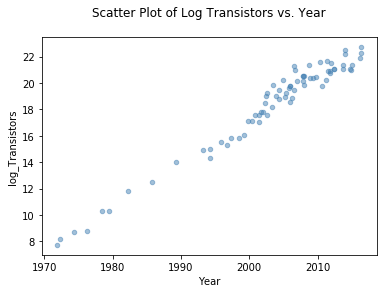

In [15]:
# Your code here
trans_df_2.select('Year','log_Transistors'). \
toPandas(). \
plot(x='Year',y='log_Transistors',kind='scatter', \
     color='steelblue',alpha=0.5, \
     title="Scatter Plot of Log Transistors vs. Year\n");

##### Grading Feedback Cell

## Question 5 Fit a Linear Regression Pipeline (10 pts)

### Question 5a ( 2 pts)
- Split trans_df_2 into train and test splits with a 60:40 ratio.  Name the resulting data frames trans_train and trans_test.  Print the shape of of the train and test data frames.

In [16]:
# your code here
# Split trans_df_2 into train and test splits with a 60:40 ratio, set seed as 7.
trans_train, trans_test = trans_df_2.randomSplit([0.6, 0.4], 7)

In [17]:
# Print the shape of of the train data frames
shape_train=(trans_train.count(),len(trans_train.columns))
print(shape_train)

(44, 3)


In [18]:
# Print the shape of of the test data frames
shape_test=(trans_test.count(),len(trans_test.columns))
print(shape_test)

(30, 3)


##### Grading Feedback Cell

### Question 5b (6 pts)
- Create a spark pipeline named trans_pipe to perform linear regression
- Fit the pipeline using the transistors as the targets and year as the features.  Name the resulting fitted pipeline fitted_trans_pipe.
- Fit another pipeline using the log transistors column as the targets and year as the features.  Name the resulting fitted pipeline log_fitted_trans_pipe.

In [19]:
# your code here
# Create a spark pipeline named trans_pipe to perform linear regression
trans_pipe = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['Year'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='Transistors')  
])

In [20]:
# Fit the pipeline using the transistors as the targets and year as the features. 
# Name the resulting fitted pipeline fitted_trans_pipe.
fitted_trans_pipe=trans_pipe.fit(trans_train)

In [21]:
# Fit another pipeline using the log transistors column as the targets and year as the features. 
# Name the resulting fitted pipeline log_fitted_trans_pipe.
log_fitted_trans_pipe=Pipeline(stages=[
  feature.VectorAssembler(inputCols=['Year'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='log_Transistors')  
]).fit(trans_train)

##### Grading Feedback Cell

### Question 5c (2 pts)
- Print the linear regression coefficient in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [22]:
# your code here
print("coefficient of fitted_trans_pipe is:\n", fitted_trans_pipe.stages[1].coefficients)
print("Y intercept of fitted_trans_pipe is:\n",fitted_trans_pipe.stages[1].intercept)

coefficient of fitted_trans_pipe is:
 [64096886.85880633]
Y intercept of fitted_trans_pipe is:
 -127544807442.83487


In [23]:
print("coefficient of log_fitted_trans_pipe is:\n",log_fitted_trans_pipe.stages[1].coefficients)
print("Y intercept of log_fitted_trans_pipe is:\n",log_fitted_trans_pipe.stages[1].intercept)

coefficient of log_fitted_trans_pipe is:
 [0.328958818274656]
Y intercept of log_fitted_trans_pipe is:
 -640.5301729647582


##### Grading Feedback Cell

### Question 6 Test the linear regression pipeline (10 pts)

### Question 6a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [24]:
# your code here
print('The MSE of \nfitted_trans_pipe model:')
mse = fn.mean((fn.col('Transistors') - fn.col('prediction'))**2).alias('mse')
fitted_trans_pipe.transform(trans_test).select(mse).show()

The MSE of 
fitted_trans_pipe model:
+--------------------+
|                 mse|
+--------------------+
|1.922108074370393...|
+--------------------+



In [25]:
print('The MSE of \nlog_fitted_trans_pipe model:')
mse = fn.mean((fn.col('log_Transistors') - fn.col('prediction'))**2).alias('mse')
log_fitted_trans_pipe.transform(trans_test).select(mse).show()

The MSE of 
log_fitted_trans_pipe model:
+-------------------+
|                mse|
+-------------------+
|0.44424679602832956|
+-------------------+



##### Grading Feedback Cell

### Question 6b (5 pts)
- Using log_fitted_trans_pipe and any needed support code, predict and print the number of transistors for the years 1970.0, 1980.0, 1990.0, 2000.0, and 2010.0

In [26]:
# Your code here
# create the dataframe for new years
test = spark.createDataFrame([(1970.0, 0), \
                              (1980.0, 0),(1990.0, 0), \
                              (2000.0, 0),(2010.0, 0)], \
                             ["Year", "log_Transistors"])
# test.show()

# Using log_fitted_trans_pipe to predict the number of transistors for new years 
prediction=log_fitted_trans_pipe.transform(test)
# prediction.show()

# The prediciton is the number of log_Transistors
# calculate the exponent of log_Transistors to get the Transistors
prediction=prediction.withColumn('Predicted Transistors', fn.exp('prediction')) 
# remove the uncessary columns
prediction=prediction.select([c for c in prediction.columns if c in {'Year','Predicted Transistors'}])
prediction.show()

+------+---------------------+
|  Year|Predicted Transistors|
+------+---------------------+
|1970.0|    1842.169139282012|
|1980.0|    49428.73523889417|
|1990.0|    1326262.510438612|
|2000.0|  3.558602578223851E7|
|2010.0|  9.548375385770988E8|
+------+---------------------+



##### Grading Feedback Cell

# Climate Change

## Question 7 Load the global warming data (5 pts)
- Read the globalWarm.txt file into a spark data frame named global_warm_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of global_warm_df 
- Print the shape of global_warm_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment
- A data description follows:
<ul>
<li/>Temp = annual surface temperature measured in 1/100<sup>o</sup> C   over the 1950-1980 mean.  
<li/>Solar = annual mean intensity of sunlight piercing the atmosphere
<li/>CO2 = annual average fraction CO<sub>2</sub> in atmosphere (#molecules/#molecules of dry air) 
<li/>IceShelf = sea ice in 1MM square miles  hypothesized to reflect heat
<li/>Transmission = volcanic MLO transmission data where eruptions release greenhouse gases but also decrease the temperature
</ul>

In [27]:
# your code here
# Read the globalWarm.txt file into a spark data frame named global_warm_df using only spark. 
# The columns should be named as per the header in the txt file.
rdd = sc.textFile("globalWarm.txt").map(lambda x: x.split("\t")) 
headers = rdd.first() 
rdd2 = rdd.filter(lambda x: x != headers)
global_warm_df = rdd2.toDF(headers) 
# Print the first 5 rows of global_warm_df
global_warm_df.show(5)

+----+----+------+-------+------------+--------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|
+----+----+------+-------+------------+--------+
|1979|   8|336.67|1366.43| 0.928466667|     7.2|
|1980|  19|338.57|1366.51| 0.929666667|    7.85|
|1981|  26|339.92|1366.51| 0.929766667|    7.25|
|1982|   4| 341.3|1366.16| 0.853066667|    7.45|
|1983|  25|342.71|1366.18| 0.897716667|    7.52|
+----+----+------+-------+------------+--------+
only showing top 5 rows



In [28]:
# Print the shape of global_warm_df (num_rows, num_cols)
shape=(global_warm_df.count(),len(global_warm_df.columns))
print(shape)

(32, 6)


In [29]:
# conver the data type of each column to proper type for further analysis
global_warm_df=global_warm_df.withColumn('Year',global_warm_df['Year'].cast('int'))
global_warm_df=global_warm_df.withColumn('Temp',global_warm_df['Temp'].cast('int'))
global_warm_df=global_warm_df.withColumn('CO2',global_warm_df['CO2'].cast('double'))
global_warm_df=global_warm_df.withColumn('Solar',global_warm_df['Solar'].cast('double'))
global_warm_df=global_warm_df.withColumn('Transmission',global_warm_df['Transmission'].cast('float'))
global_warm_df=global_warm_df.withColumn('IceShelf',global_warm_df['IceShelf'].cast('double'))
# global_warm_df.printSchema()

##### Grading Feedback Cell

## Question 8 Global Warming Data Exploration (5 pts)
- Create a temperature vs. year scatter plot from global_warm_df
- You may use packages outside of spark for this question

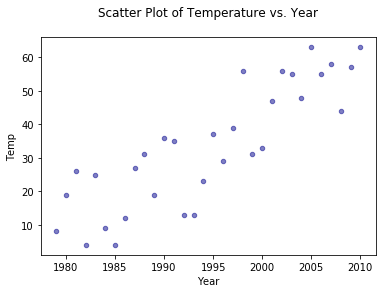

In [30]:
# your code here
global_warm_df.select('Year','Temp'). \
toPandas(). \
plot(x='Year',y='Temp',kind='scatter', \
     color='darkblue',alpha=0.5, \
     title="Scatter Plot of Temperature vs. Year\n");

##### Grading Feedback Cell

## Question 9 Global Warming Data Exploration (10 pts)


### Question 9a (5 pts)
- Using global_warm_df, create a pair plot of the following variables in a grid:  Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf.
- You may use packages outside of spark for this question

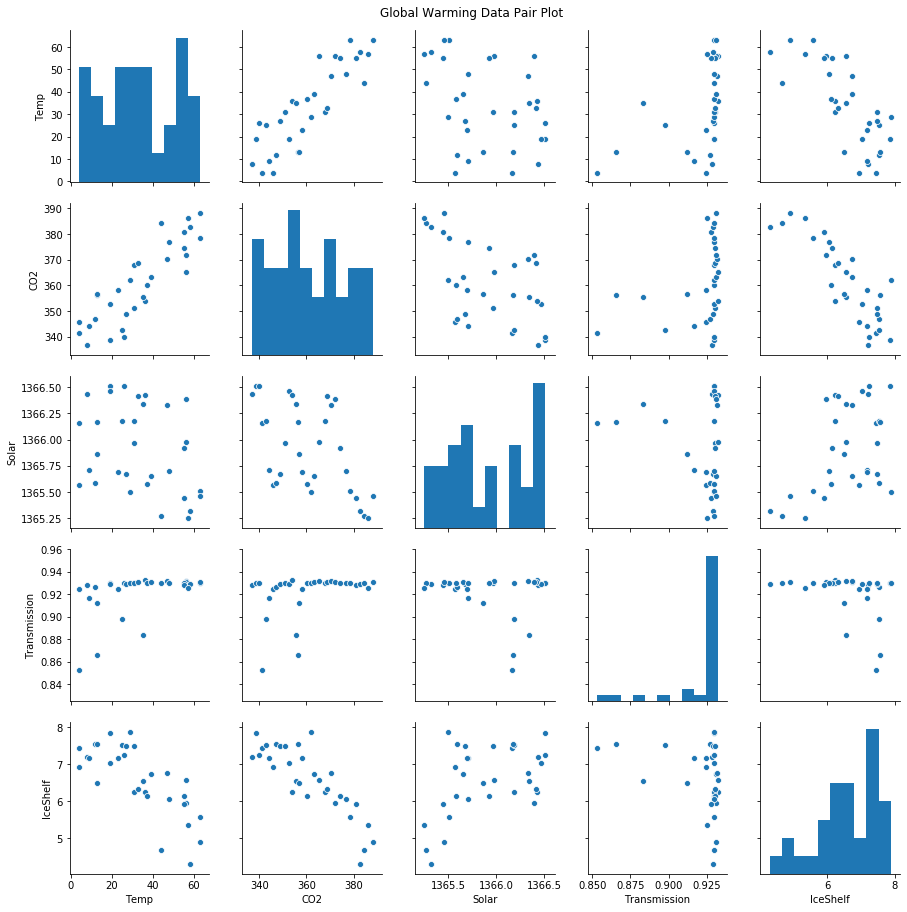

In [31]:
# your code here
ax = sns.pairplot(global_warm_df.toPandas()[['Temp', 'CO2', 'Solar', 'Transmission', 'IceShelf']])
ax.fig.suptitle("Global Warming Data Pair Plot", y=1.01);

##### Grading Feedback Cell

### Question 9b (5 pts)
- Compute a correlation matrix between Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf using spark.
- Print a labeled correlation matrix.

In [32]:
# your code here
variables_corr=headers[1:]  # Year is not used in this question
assembler = feature.VectorAssembler(inputCols=variables_corr,outputCol="corr_features")  # combines a given list of columns into a single feature vector
output = assembler.transform(global_warm_df)      # transforms global_warm_df with features into a DataFrame with "corr_features"
cor_df=Correlation.corr(output, "corr_features")  # Correlation.corr(dataset, column, method='pearson')
                                                  # column: The name of the column of vectors for which the correlation coefficient needs to be computed. 
                                                  # This must be a column of the dataset, and it must contain Vector objects.
cor_matrix=cor_df.collect()[0][0]                 # cor_df is a pyspark.sql.dataframe , we need to extract the matrix
rows = cor_matrix.toArray().tolist()              # convert the matrix to list for future presence
correlation_df = spark.createDataFrame(rows,['col1','col2','col3','col4','col5'])
variables_rdd = sc.parallelize(variables_corr)    # Add the variables name as the first column
correlation_df=spark.createDataFrame(correlation_df.rdd.zip(variables_rdd).map(lambda x: (x[1],x[0][0], x[0][1],x[0][2],x[0][3],x[0][4])), [' ','Temp', 'CO2', 'Solar', 'Transmission', 'IceShelf'])
correlation_df.show()
# correlation_df.toPandas() can be used if the original df is messy.

+------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|            |                Temp|                CO2|               Solar|        Transmission|            IceShelf|
+------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|        Temp|                 1.0| 0.8609274427038354|-0.34034204115225913| 0.43539404481653526| -0.7474254977372596|
|         CO2|  0.8609274427038354|                1.0| -0.5428218983657372| 0.32822759918911637| -0.8469607794109111|
|       Solar|-0.34034204115225913|-0.5428218983657372|                 1.0| -0.2058479518009041|  0.4706898204511034|
|Transmission| 0.43539404481653526|0.32822759918911637| -0.2058479518009041|                 1.0|-0.30248395981398685|
|    IceShelf| -0.7474254977372596|-0.8469607794109111|  0.4706898204511034|-0.30248395981398685|                 1.0|
+------------+--------------------+-------------

##### Grading Feedback Cell 

## Question 10 Fit Linear Regression Pipelines (10 pts)

### Question 10a (2 pts)
Split global_warm_df into train and test splits with a 60:40 ratio.  Name the resulting data frames gw_train and gw_test.  Print the shape of of the train and test data frames.   

In [33]:
# your code here
# Split global_warm_df into train and test splits with a 60:40 ratio.
gw_train,gw_test=global_warm_df.randomSplit([0.6, 0.4], 7)
# Print the shape of of the train data frames
print((gw_train.count(),len(gw_train.columns)))
#print("number of columns of gw_train:",len(gw_train.columns))

(19, 6)


In [34]:
# Print the shape of of the test data frames
# print("number of rows of gw_test:",gw_test.count())
# print("number of columns of gw_test:",len(gw_test.columns))
print((gw_test.count(),len(gw_test.columns)))

(13, 6)


##### Grading Feedback Cell

### Question 10b (6 pts)
- Create a spark pipeline named global_warm_pipe to perform linear regression.
- Use the global_warm_df data frame
- Fit a pipeline on the temp column as the target and CO2 as the feature.  Name the resulting fitted pipeline fitted_global_warm_pipe.
- Fit another pipeline on the temp column as the target and all other columns except year as the features.  Name the resulting fitted pipeline fitted_global_warm_pipe_2.

In [35]:
# your code here
global_warm_pipe=Pipeline(stages=[feature.VectorAssembler(inputCols=['CO2'],
                                        outputCol='features'),
                  regression.LinearRegression(labelCol='Temp', featuresCol='features')])
fitted_global_warm_pipe=global_warm_pipe.fit(gw_train)

In [36]:
fitted_global_warm_pipe_2=Pipeline(stages=[feature.VectorAssembler(inputCols=['CO2', 'Solar', 'Transmission', 'IceShelf'],
                                        outputCol='features'),
                  regression.LinearRegression(labelCol='Temp', featuresCol='features')]).fit(gw_train)

##### Grading Feedback Cell

### Question 10c (2 pts)
- Print the linear regression coefficient(s) in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [37]:
# your code here
print("coefficient of fitted_global_warm_pipe is:\n",fitted_global_warm_pipe.stages[1].coefficients)
print("Y intercept of fitted_global_warm_pipe is:\n",fitted_global_warm_pipe.stages[1].intercept)

coefficient of fitted_global_warm_pipe is:
 [1.010937987055483]
Y intercept of fitted_global_warm_pipe is:
 -329.632265555407


In [38]:
print("coefficients of fitted_global_warm_pipe_2 are:\n",fitted_global_warm_pipe_2.stages[1].coefficients)
print("Y intercept of fitted_global_warm_pipe_2 is:\n",fitted_global_warm_pipe_2.stages[1].intercept)

coefficients of fitted_global_warm_pipe_2 are:
 [1.1308572156189602,7.663611979644797,267.78935667875106,1.414477956736755]
Y intercept of fitted_global_warm_pipe_2 is:
 -11097.361309915506


##### Grading Feedback Cell

### Question 11 Test the linear regression pipeline (10 pts)

### Question 11a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [39]:
# your code here
mse = fn.mean((fn.col('Temp') - fn.col('prediction'))**2).alias('mse')
print('The MSE of \nfitted_global_warm_pipe:')
fitted_global_warm_pipe.transform(gw_test).select(mse).show()

The MSE of 
fitted_global_warm_pipe:
+-----------------+
|              mse|
+-----------------+
|84.19203375744239|
+-----------------+



In [40]:
print('The MSE of \nfitted_global_warm_pipe_2:')
fitted_global_warm_pipe_2.transform(gw_test).select(mse).show()

The MSE of 
fitted_global_warm_pipe_2:
+-----------------+
|              mse|
+-----------------+
|81.39071782817888|
+-----------------+



##### Grading Feedback Cell

### Question 11b (5 pts)
- Which of the 2 models have higher performance.  In the cell below, describe why you think the better performing model made the model perform better.

Model 2 (fitted_global_warm_pipe_2) has higher performance because its mse is lower than Model 1. The reason why Model 2 performs better is that it takes more predictor ('CO2', 'Solar', 'Transmission', 'IceShelf') than Model 1 (only 'CO2'). <br/>Though more predictors do not necessarily increase model's performance. In our case, two predictors are highly related to the target, 'CO2' and 'IceShelf'. Model 1 only contains 'CO2' while model 2 contains more variables and some are highly related to the target, so it performs better. As we can see, the predcitor 'IceShelf' in model 2 is highly negatively related to the target 'Temp', which means this predictor would be useful in predicting the target variable and increases the performance of model. <br/>

### Question 12 Inference (10 pts)

### Question 12a Data Scaling (5 pts)
Add data scaling to fitted_global_warm_pipe_2 above. Name the resulting fitted model fitted_global_warm_pipe_3.  Print the resulting fitted model coefficients such that each coefficient is clearly labeled with it's corresponding feature name.

In [41]:
# your code here
fitted_global_warm_pipe_3=Pipeline(stages=[feature.VectorAssembler(inputCols=['CO2', 'Solar', 'Transmission', 'IceShelf'], \
                                        outputCol='features'),feature.StandardScaler(withMean=True,withStd=True, \
                                                                                     inputCol='features',outputCol="scaled_features"), \
                                           regression.LinearRegression(labelCol='Temp', featuresCol='scaled_features')]).fit(gw_train)

coef=fitted_global_warm_pipe_3.stages[-1].coefficients.values
print("Y intercept of fitted_global_warm_pipe_3 is:\n",fitted_global_warm_pipe_3.stages[-1].intercept)
print("\n")
print("Coefficients of fitted_global_warm_pipe_3 are:")
print("scaled_CO2: "+str(coef[0]))
print("scaled_Solar: "+str(coef[1]))
print("scaled_Transmission: "+str(coef[2]))
print("scaled_IceShelf: "+str(coef[3]))

Y intercept of fitted_global_warm_pipe_3 is:
 37.21052631579007


Coefficients of fitted_global_warm_pipe_3 are:
scaled_CO2: 17.896086967663898
scaled_Solar: 3.163742218597929
scaled_Transmission: 4.309546826953219
scaled_IceShelf: 1.426320749007481


In [42]:
# Summarize the model over the training set and print out some metrics
# reference: https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#generalized-linear-regression
summary = fitted_global_warm_pipe_3.stages[-1].summary
pValues=summary.pValues
print("P-Values of estimated coefficients and intercept of fitted_global_warm_pipe_3 are:")
print("scaled_CO2: "+str(pValues[0]))
print("scaled_Solar: "+str(pValues[1]))
print("scaled_Transmission: "+str(pValues[2]))
print("scaled_IceShelf: "+str(pValues[3]))
print("intercept: "+str(pValues[4]))
print("\n")
print("Adjusted Rsquared: %f" % summary.r2adj)

P-Values of estimated coefficients and intercept of fitted_global_warm_pipe_3 are:
scaled_CO2: 0.0028029614604871966
scaled_Solar: 0.2810588707418993
scaled_Transmission: 0.11148202014495778
scaled_IceShelf: 0.790880423953976
intercept: 1.0708522957258992e-10


Adjusted Rsquared: 0.735653


### Question 12b Inference (5 pts)  
Use the coefficients printed above to gain insights into the global warming problem. Describe your inference conclusions in the cell below.

Coefficient inference conclusions here:<br/>
<br/>
Regression coefficients represent the mean change in the response variable for one unit of change in the predictor variable while holding other predictors in the model constant. <br/>
<br/>
The coefficient of scaled_CO2, 17.896, implies that in our sample each additional scaled_CO2 is associated with 17.896 higher temperature. <br/>
<br/>
The coefficient of scaled_Solar, 3.164, suggests that a single additional scaled_Solar is associated with an additional 3.164 in temperature. <br/>
<br/>
The coefficient of scaled_Transmission, 4.310, implies that in each additional scaled_Transmission is associated with 4.310 higher temperature. <br/>
<br/>
The coefficient of scaled_IceShelf, 1.426, suggests that a single additional scaled_IceShelf is associated with an additional 1.426 in temperature. <br/>
<br/>
These coefficients table implies the equation for the best fitting line is given by: <br/>
**Temperature = 37.210 + 17.896 * scaled_CO2 + 3.164 * scaled_Solar + 4.310 *  scaled_Transmission + 1.426 * scaled_IceShelf.**

However, by checking the P-value of these predictor, we can see that scaled_Solar, scaled_Transmission, scaled_IceShelf have a P-value higher than a significance level equal to 5%, suggests that changes in these predictor are not significantly associated with changes in the temperature. Typically, we use the coefficient p-values to determine which terms to keep in the regression model. In the model above, we should consider removing scaled_Solar, scaled_Transmission, scaled_IceShelf.

##### Grading Feedback Cell

# Question 13 Extra Credit (10 pts)
This question is optional.  No points will be deducted from your score if you do not attempt this problem.<br>

Starting with the rdd class presented in lecture (maintaining all class method names), implement a my_reduce method in the rdd class.  Your implementation shall maintain rdd class immutability.  Your my_reduce method return type should be consistent with the return type in the real Spark reduce method. Do some research and see what the Spark reduce return type would be.  <br>

Implement a function named times_3 which returns its input multiplied by 3. Implement a function named is_even that returns true if it's input is even, false otherwise.  Implement a my_sum function that returns the sum of its 2 inputs.  <br>

Your overall implementation should not rely on receiving specific data types as inputs.  For example, the plus operator works on more than just ints and floats.

In [43]:
# your code here
# define our own simple as possible rdd class
def times_3(x):
    return x*3 

def is_even(x):
    if x%2 == 0:
        return True
    else:
        return False
    
def my_sum(x1,x2):
    return x1+x2

class rdd:
    def __init__(self, arg_array):
        self.local_array = arg_array
    
    # define our own map function
    def my_map(self, fun):
        if len(self.local_array) < 1:
            raise Exception("my_map: len(local_array) < 1")
        
        # create a new numpy array to hold the result
        # remember that rdd's are supposed to be immutable
        mapped = np.empty_like(self.local_array)
        
        # for each element in the local array
        for i, el in enumerate(self.local_array):
            # execute the user defined function on this element
            mapped[i] = fun(self.local_array[i])
        
        # This is the key to how the data is passed.  The return value is another rdd object!
        # The fact that we are returning a new rdd is the key to how chaining works
        # create a new rdd using the array created by applying the user defined function
        return rdd(mapped)
    
    def my_filter(self, fun):
        # create a temporary list to store the filtered results
        transformed = []

        for el in self.local_array:
            if fun(el):
                transformed.append(el)
                
        return rdd(np.array(transformed))
    
    def my_reduce (self, fun):
        total=self.local_array[0]
        
        for i in range(1,len(self.local_array)):
            total=fun(total,self.local_array[i])
            
        return total
        
    def collect(self):
        return self.local_array

In [44]:
# Simple test code
test_rdd = rdd(np.arange(100))
result = test_rdd.my_map(times_3).my_filter(is_even).my_reduce(my_sum)
print(type(result))
print(result)
# secret grading test code follows

<class 'numpy.int64'>
7350


# Grading Feedback Cell
+10: Nicely done!